In [1]:
import numpy as np
import pandas as pd
import glob, os
import itertools
import matplotlib.image as mpimg
import pickle
import math
import json
from functools import *
from sklearn.metrics import *

%matplotlib inline
import matplotlib.pyplot as plt

MAX_FRAME_NUM = 1000000

In [2]:
failure_starts = pd.read_csv('/Users/kenneth/Projects/ga-ml/tsd/val_mp4s.csv', header=None, index_col=0).sample(frac=1)
failure_starts.index = failure_starts.index.map(int)
failure_starts['start1'] = MAX_FRAME_NUM
failure_starts['start2'] = MAX_FRAME_NUM

selected_failure_starts = pd.read_csv('/Users/kenneth/Projects/ga-ml/tsd/failure_starts.csv', index_col=0, names=['start1', 'start2'])
selected_failure_starts.index = selected_failure_starts.index.map(int)
# selected_failure_starts['start1'] = selected_failure_starts['start1']*25/30 # account for the 25fps vs 30 fps bug in the code.
# selected_failure_starts['start2'] = selected_failure_starts['start2']*25/30 # account for the 25fps vs 30 fps bug in the code.
max_id = max(selected_failure_starts.index)
failure_starts = failure_starts[failure_starts.index <= max_id]
failure_starts = failure_starts[failure_starts.index >= 4572]
failure_starts.update(selected_failure_starts)
failure_starts.loc[failure_starts['start2'] < 0, 'start2'] = MAX_FRAME_NUM

vids = failure_starts.index.values.tolist()
failed_vids = failure_starts[failure_starts.start1 < MAX_FRAME_NUM].index.values
succeeded_vids = failure_starts[failure_starts.start1 >= MAX_FRAME_NUM].index.values
np.random.shuffle(failed_vids)
np.random.shuffle(succeeded_vids)


In [4]:
# baselione - prod performance. Precision: 0.21.  Recall - 0.45

def load_df_from_json(fn):
    if not os.path.isfile(fn):
        return pd.DataFrame()
    l = [ f['fields'] for f in json.load(open(fn, 'r')) if 'fields' in f]
    df = pd.DataFrame(l)
    return df

# def validate_ewm(fn):
#     df = load_df_from_json(fn)
#     if df.empty:
#         return
#     ser = ((df['ewm_mean'] - df['rolling_ewm'])[20:] > 1e-03)
#     return ser[ser].count() == 0

# for vid in alerted.index.values:
#     print(vid)
#     print(validate_ewm('/mnt/ml-data4/tsd/jsons/{}.json'.format(vid)))

def load_detections(vid):
    return load_df_from_json('/mnt/ml-data4/tsd/jsons/{}.json'.format(vid))

settings = dict(THRESHOLD_LOW=0.11, THRESHOLD_HIGH=0.65, INIT_SAFE_FRAME_NUM=30, ROLLING_MEAN_SHORT_MULTIPLE=5.43)

def is_failing(prediction, detective_sensitivity=1.0):
    if prediction.current_frame_num < settings['INIT_SAFE_FRAME_NUM']:
        return False

    adjusted_ewm_mean = prediction.ewm_mean * detective_sensitivity
    if adjusted_ewm_mean < settings['THRESHOLD_LOW'] + prediction.rolling_mean_long:
        return False

    if adjusted_ewm_mean > settings['THRESHOLD_HIGH'] + prediction.rolling_mean_long:
        return True

    if adjusted_ewm_mean > prediction.rolling_mean_short * settings['ROLLING_MEAN_SHORT_MULTIPLE']:
        return True
    
    return False

def detect_failure_start(vid, plot=False, **args):
    det = load_detections(vid)
    if plot:
        det[['current_p', 'ewm_mean', 'rolling_mean_short', 'rolling_mean_long']].plot()

    print(vid)
    det['is_failing'] = det.apply(is_failing, axis=1)
    failing_frames = det[det['is_failing']].index

    if len(failing_frames) > 0:
        return det[det['is_failing']].index[0]


In [3]:
raw_dets = []
for pkl in ['prod1.pkl', 'prod2.pkl', 'prod3.pkl', 'prod4.pkl', 'prod5.pkl', 'prod6.pkl', 'prod7.pkl', 'prod8.pkl', 'prod9.pkl', 'prod10.pkl']:
    raw_dets = raw_dets + pickle.load( open( "/Users/kenneth/Projects/ga-ml/tsd/neg_32213_22300.out/"+pkl, "rb" ) )

dets_map = dict()
for det in raw_dets:
    vid = int(det[0].split('-')[1].split('/')[-1])
    fid = int(det[0].split('-')[2].split('.')[0])
    dets_map.setdefault(vid, []).append([fid, det[1][0][1], det[1][1][1], det[1][2][1]])


In [45]:

def clip(x, lower):
    if x < lower:
        return 0
    return x

def pseudo_moving_avg(input, win_size):
    mean = 0
    output = []
    for j, i in enumerate(input):
        diff =  (i - mean )/float(win_size if win_size < j else j+1)
        mean = mean + diff
        output += [mean]
    
    return output

def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
    avgs = np.array(pseudo_moving_avg(df.accu_detection, rolling_win))
    df['rolling_mean'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    return df.set_index('fid')


In [5]:
START1_RELAX = 2
START2_RELAX = 30

def eval_vids(vids_to_work_on, plot=False, **args):
    results = dict(p=[], fp=[], fn=[], tp=[], tn=[])
    for vid in vids_to_work_on:
        if plot:
            plt.figure()

        detected_failure_start = detect_failure_start(vid, plot=plot, **args)
#         detected_failure_start = detect_failure_start(vid, plot)
        if detected_failure_start == None:
            detected_failure_start = MAX_FRAME_NUM

        start1 = failure_starts.loc[int(vid)].start1
        start2 = failure_starts.loc[int(vid)].start2

        if (start1) < MAX_FRAME_NUM:
            results.get('p').append(vid)

        if detected_failure_start < start1 - START1_RELAX :
            result = 'fp'
        elif detected_failure_start > start2 + START2_RELAX:
            result = 'fn'
        elif detected_failure_start < MAX_FRAME_NUM:
            result = 'tp'
        else:
            result = 'tn'
        results.get(result).append(vid)

        if plot:
            if start1 < MAX_FRAME_NUM:
                plt.plot([start1, start1],[0,1], linestyle='-', color='y')
            if start2 < MAX_FRAME_NUM:
                plt.plot([start2, start2],[0,1], linestyle='-', color='r')
            if detected_failure_start < MAX_FRAME_NUM:
                plt.plot([detected_failure_start, detected_failure_start],[0,1], linestyle='-', color='b')
            plt.title(str(vid) + result)
    return results

# results = eval_vids(np.hstack((failed_videos.tail(30).index.values, succeeded_videos.tail(50).index.values)), False)
# results = eval_vids(np.hstack((failed_videos.head(20).index.values, succeeded_videos.head(50).index.values)))

# results = eval_vids(vids, rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06)


# rolling avg based prediction.

Precision: 0.15 Recall: 0.29 based on production params (except long term rolling avg)


In [133]:

def truncated(x, lower, upper):
    if x < lower:
        return -math.inf
    if x > upper:
        return math.inf
    return x

def detect_failure_start(vid, thresh, v_thresh, min_ewm, ewm_span, rolling_win, rolling_multiple, plot=False):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    df['rolling_mean'] = df['rolling_mean'] * rolling_multiple
    detected_failures = df.index[df.rolling_ewm.apply(truncated, args=(min_ewm, v_thresh)) > df.rolling_mean]
    if plot:
        plt.figure()
        df[['rolling_ewm','rolling_mean']].plot()

    if len(detected_failures) > 0:
        return detected_failures.min()
    
results = eval_vids(val_vids, rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.3206106870229008 - F0.5: 0.4449152542372881 - Precision: 0.6 - Recall: 0.21875
14 23 21


# Baseline. Simple prediction 

In [25]:
def detect_failure_start(vid, plot=False):
    df = load_detections(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50)
    if len(df[df.accu_detection > 0.85]) > 5:
        return df[df.accu_detection > 0.85].index[4]

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

results = eval_vids(val_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.37 - F0.5: 0.41 - Precision: 0.44 - Recall: 0.32
FP: 40 - FN: 18 - TP: 31 - P: 96


# Random Forest

`failure_point` is mid point between `start1` and `start2`

Feature selection

In [78]:
# feature_list = ['p1', 'p2', 'p3', 'accu_detection', 'rolling_ewm', 'rolling_mean']
feature_list = ['p1', 'p2', 'rolling_meaning']

def load_as_xy(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    df['r'] = (df['rolling_ewm']/df['rolling_mean'].clip(0.0001)).clip(0,30)
    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    x = df[feature_list].to_numpy()
    
    y = np.zeros((len(df), 1))
    failure_point = start1 + (start2-start1)//2

    y[failure_point:] = 1
    return np.concatenate([y, x], axis=1)

def detect_failure_start(vid, plot=False):
    x = load_as_xy(vid, plot)
    y = model.predict(x[:,1:]) 
    if len(np.nonzero(y)[0]) > 0:
        if plot:
            for fr in np.nonzero(y)[0]:
                plt.plot([fr, fr],[0,1], linestyle='-', color='y')
        return np.nonzero(y)[0][0]

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])


1. p2 - (0.483466)
2. rolling_ewm - (0.447792)
3. p1 - (0.068742)


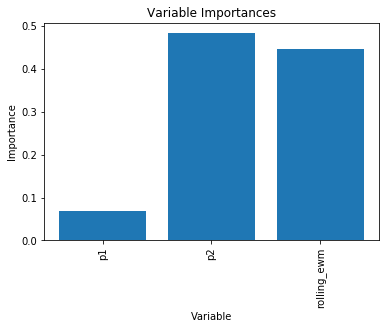

In [79]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42, n_estimators=7, max_depth=2)
model.fit(training_ds[:,1:],training_ds[:,0])

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(training_ds[:,1:].shape[1]):
    print("%d. %s - (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

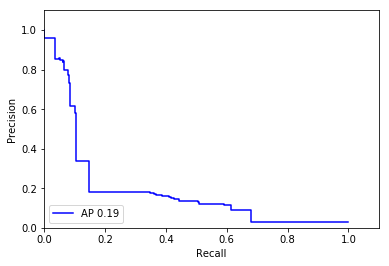

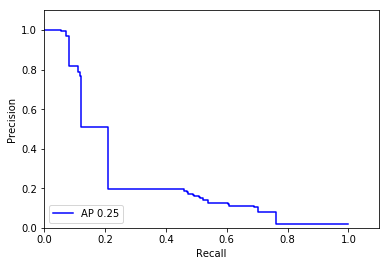

In [80]:
y = model.predict_proba(training_ds[:,1:])  
precision, recall, _ = precision_recall_curve(training_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(training_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

y = model.predict_proba(val_ds[:,1:])  
precision, recall, _ = precision_recall_curve(val_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(val_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

In [81]:
results = eval_vids(training_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))

results = eval_vids(val_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.09 - F0.5: 0.17 - Precision: 0.42 - Recall: 0.05
FP: 7 - FN: 32 - TP: 5 - P: 100
Failure detection on test videos: F1: 0.04 - F0.5: 0.09 - Precision: 0.50 - Recall: 0.02
FP: 2 - FN: 35 - TP: 2 - P: 96


In [61]:
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = model.estimators_[5]

export_graphviz(tree, out_file = '/tmp/tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('/tmp/tree.dot')
# Write graph to a png file
graph.write_png('/tmp/tree.png')

# Logistic Regression

It underfits, even with a lot more features than Random Forest. 

In [160]:

def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
    df['rolling_ewm_5'] = df.accu_detection.ewm(span=5).mean()
    df['rolling_ewm_20'] = df.accu_detection.ewm(span=20).mean()
    df['rolling_ewm_50'] = df.accu_detection.ewm(span=50).mean()
    avgs = np.array(pseudo_moving_avg(df.accu_detection, rolling_win))
    df['rolling_mean'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    avgs = np.array(pseudo_moving_avg(df.accu_detection, 100))
    df['rolling_mean_100'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    avgs = np.array(pseudo_moving_avg(df.accu_detection, 200))
    df['rolling_mean_200'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    df['r'] = (df['rolling_ewm']/df['rolling_mean'].clip(0.0001)).clip(0,10)
    df['r1'] = (df['rolling_ewm']/df['rolling_ewm_20'].clip(0.0001)).clip(0,10)
    df['r2'] = (df['rolling_ewm']/df['rolling_ewm_50'].clip(0.0001)).clip(0,10)
    df['r3'] = (df['rolling_ewm']/df['rolling_mean_200'].clip(0.0001)).clip(0,10)

    return df.set_index('fid')

def load_as_xy(vid, clip_to_failure=False, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    x = df.to_numpy()
    
    y = np.zeros((len(df), 1))
    failure_point = (start1+start2)//2

    y[failure_point:] = 1
#     if clip_to_failure:
#         failure_point = min(failure_point, len(df))
#         frames = np.hstack([(np.random.randint(0, failure_point, size=3) if failure_point > 2 else []), np.arange(failure_point, min(failure_point+10, len(df)))]).astype(np.int32)
#         return np.concatenate([y, x], axis=1)[frames,:]
#     else:
    return np.concatenate([y, x], axis=1)

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])

In [162]:
val_ds.shape

(984863, 16)

/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


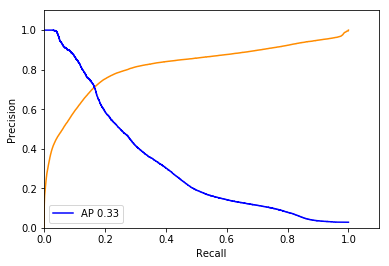

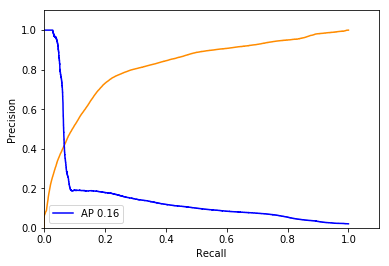

Failure detection on training videos:  0.20800000000000002 0.325 0.52 0.13
12 25 13
Failure detection on test videos:  0.1206896551724138 0.19886363636363638 0.35 0.07291666666666667
13 30 7


In [165]:

from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(random_state=0)
model.fit(training_ds[:,1:],training_ds[:,0])

y = model.predict_proba(training_ds[:,1:])  
fpr, tpr, _ = roc_curve(training_ds[:,0], y[:,1])
plt.plot(fpr, tpr, color='darkorange')
precision, recall, _ = precision_recall_curve(training_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(training_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

y = model.predict_proba(val_ds[:,1:])  
fpr, tpr, _ = roc_curve(val_ds[:,0], y[:,1])
plt.plot(fpr, tpr, color='darkorange')
precision, recall, _ = precision_recall_curve(val_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(val_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

results = eval_vids(training_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on training videos: ", f1, f0_5, precision, recall)
print(len(results['fp']), len(results['fn']), len(results['tp']))


results = eval_vids(val_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: ", f1, f0_5, precision, recall)
print(len(results['fp']), len(results['fn']), len(results['tp']))


# Random Forest 

soft failure (`start1`) = 1
hard failure (`start2`) = 2


In [41]:
# feature_list = ['p1', 'p2', 'p3', 'rolling_ewm']
feature_list = ['p1', 'p2', 'p3', 'rolling_ewm', 'rolling_ewm_10', 'rolling_ewm_20', 'rolling_ewm_30', 'r10', 'r20', 'r30']


def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
    df['rolling_ewm_10'] = 0
    df['rolling_ewm_20'] = 0
    df['rolling_ewm_30'] = 0
    df['r10'] = 0
    df['r30'] = 0
    df.loc[df.index[10:], 'rolling_ewm_10'] = df.loc[df.index[:-10], 'rolling_ewm'].to_numpy()
    df.loc[df.index[20:], 'rolling_ewm_20'] = df.loc[df.index[:-20], 'rolling_ewm'].to_numpy()
    df.loc[df.index[30:], 'rolling_ewm_30'] = df.loc[df.index[:-30], 'rolling_ewm'].to_numpy()
    df['r10'] = (df['rolling_ewm']/df['rolling_ewm_10'].clip(0.0001)).clip(0,10)
    df['r20'] = (df['rolling_ewm']/df['rolling_ewm_20'].clip(0.0001)).clip(0,10)
    df['r30'] = (df['rolling_ewm']/df['rolling_ewm_30'].clip(0.0001)).clip(0,10)

    return df.set_index('fid')


def load_as_xy(vid, clip_to_failure=False, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    # give a bit of leeway for start1 since it is a very conservative point
    start1 = start1 + (start2 - start1)//5

#     df['has_failed'] = 0
#     df.loc[start1+5:, 'has_failed'] = 1
#     df.loc[start2+5:, 'has_failed'] = 2
    x = df[feature_list].to_numpy()

    y = np.zeros((len(df), 3))
    y[:start1, 0] = 1
    y[start1:start2, 1] = 1
    y[start2:, 2] = 1
    
    ds = np.concatenate([y[30:,:], x[30:,:]], axis=1)
    
    return ds
    # balance dataset
    y_zeros = ds[ds[:,0] < 1]
    y_nonzeros = ds[ds[:,0] >= 1]
    max_y_zeros = max(len(y_nonzeros), 2)
    
    np.random.shuffle(y_zeros)
    return np.vstack([y_nonzeros, y_zeros[:max_y_zeros,:]])
    


def detect_failure_start(vid, plot=False):
#     df = load_detections(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50)
#     df['r'] = (df['rolling_ewm']/df['rolling_mean'].clip(0.0001)).clip(0,30)
    
#     has_failed = 0
#     has_failed_arr = np.array([])
#     failed_frame = None
    
#     for index, row in df.iterrows():
#         x = row[feature_list].to_numpy()
# #         x = np.append(x, [has_failed])
#         has_failed = model.predict(x.reshape(1, -1))[0]
#         if has_failed == 1 and failed_frame == None:
#             failed_frame = index
        
#         has_failed_arr = np.append(has_failed_arr, [has_failed])

#     if plot:
#         plt.plot(df.rolling_ewm)
#         plt.plot(has_failed_arr)
            
#     return failed_frame

    x = load_as_xy(vid, plot)
    if len(x) == 0:
        return None
    
    y = model.predict(x[:,3:])
    
    if plot:
        plt.plot(np.append(np.zeros(30), model.predict_proba(x[:,3:])[1][:,1]), color='b')
        plt.plot(np.append(np.zeros(30), model.predict_proba(x[:,3:])[2][:,1]), color='r')
        plt.plot(np.append(np.zeros(30), x[:,6]), color='g')

    if len(np.nonzero(y[:,1:])[0]) > 0:
        return np.nonzero(y[:,1:])[0][0] + 30

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
# val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])


1. rolling_ewm_10 - (0.156698)
2. rolling_ewm - (0.136720)
3. r20 - (0.110835)
4. rolling_ewm_30 - (0.110189)
5. p3 - (0.101431)
6. rolling_ewm_20 - (0.098281)
7. p1 - (0.075330)
8. r10 - (0.074113)
9. r30 - (0.070089)
10. p2 - (0.066313)


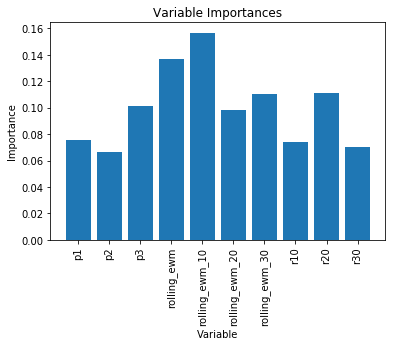

In [42]:

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42, n_estimators=10, max_depth=15)
model.fit(training_ds[:,3:],training_ds[:,:3])

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(training_ds[:,3:].shape[1]):
    print("%d. %s - (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [43]:

results_t = eval_vids(training_vids)
results = results_t
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))

results_v = eval_vids(val_vids)
results = results_v
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))

Failure detection on test videos: F1: 0.61 - F0.5: 0.73 - Precision: 0.84 - Recall: 0.48
FP: 9 - FN: 6 - TP: 48 - P: 100
Failure detection on test videos: F1: 0.27 - F0.5: 0.28 - Precision: 0.30 - Recall: 0.24
FP: 54 - FN: 25 - TP: 23 - P: 96


/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

{'fn': [],
 'fp': [],
 'p': [6221,
  6393,
  5947,
  10533,
  4595,
  5970,
  4637,
  11255,
  11271,
  10892,
  10771,
  5249,
  5241,
  5062,
  5890,
  5930,
  10442,
  11084,
  6223,
  10675,
  10862,
  10692,
  5553,
  6156,
  5808,
  10113,
  6194,
  6112,
  10432],
 'tn': [],
 'tp': [6221,
  6393,
  5947,
  10533,
  4595,
  5970,
  4637,
  11255,
  11271,
  10892,
  10771,
  5249,
  5241,
  5062,
  5890,
  5930,
  10442,
  11084,
  6223,
  10675,
  10862,
  10692,
  5553,
  6156,
  5808,
  10113,
  6194,
  6112,
  10432]}

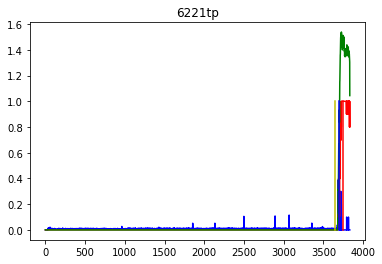

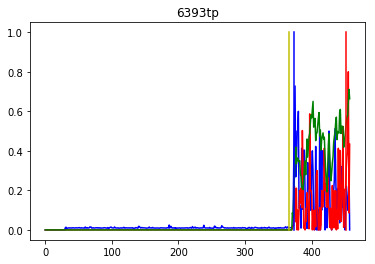

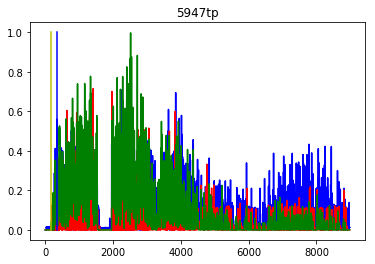

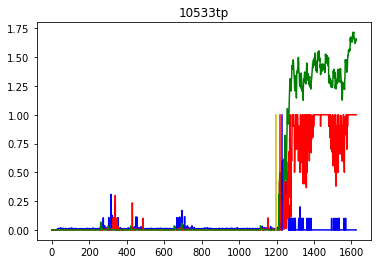

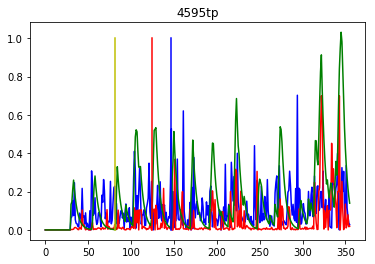

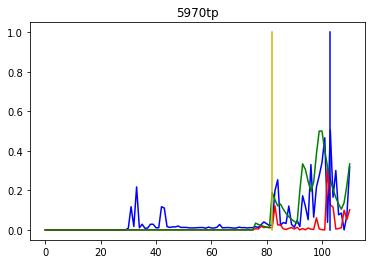

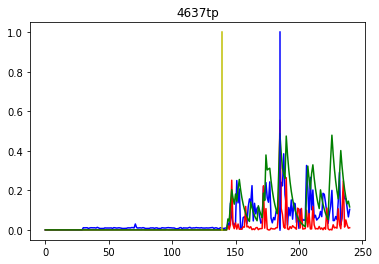

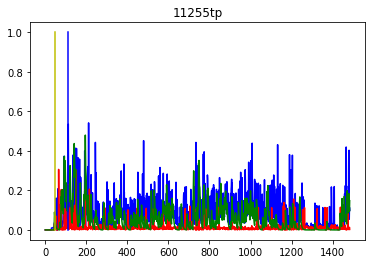

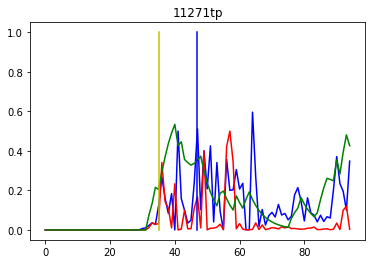

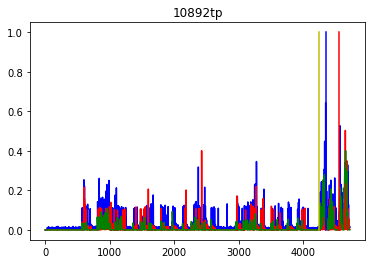

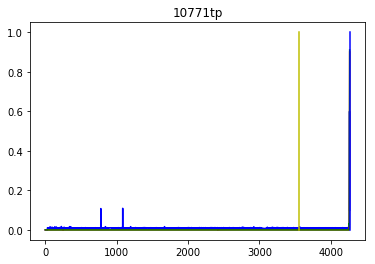

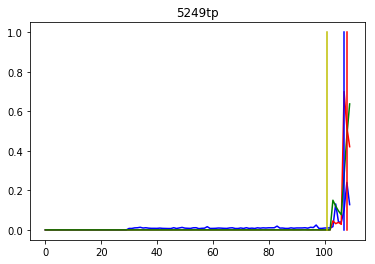

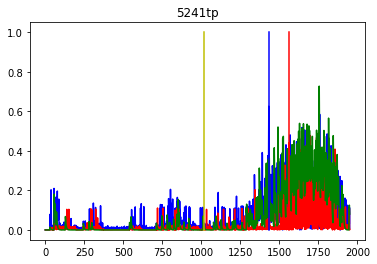

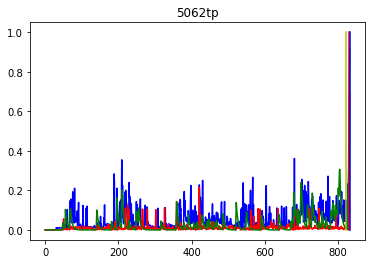

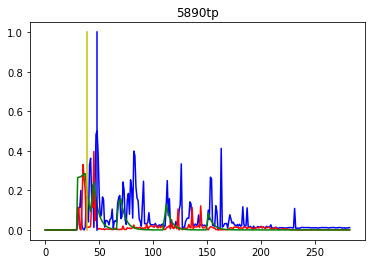

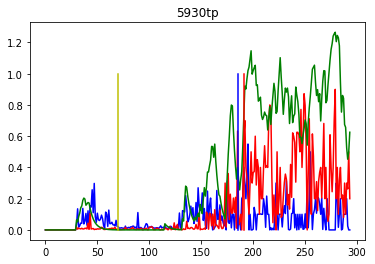

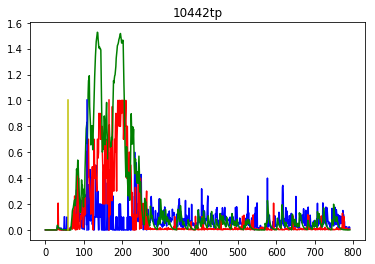

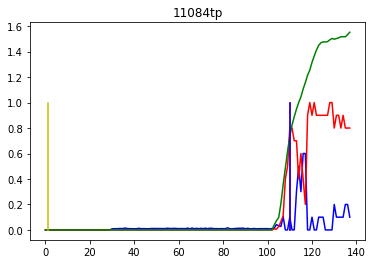

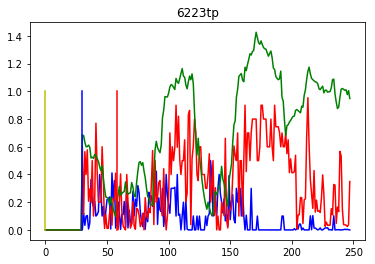

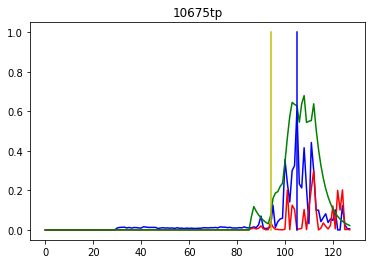

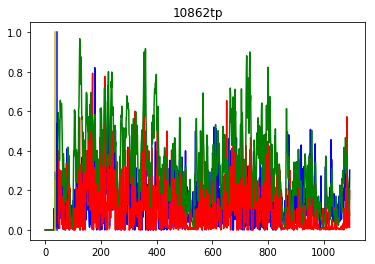

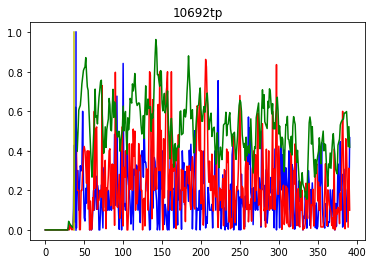

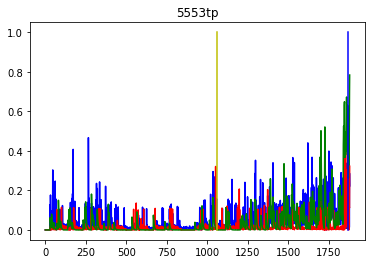

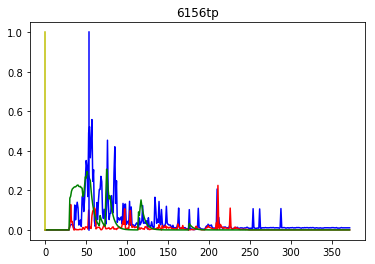

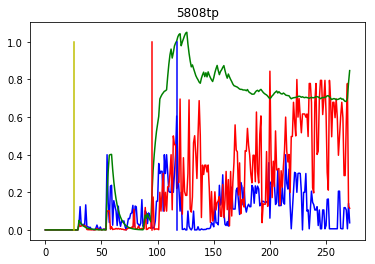

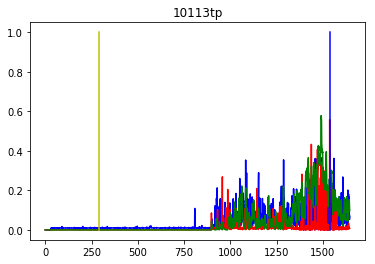

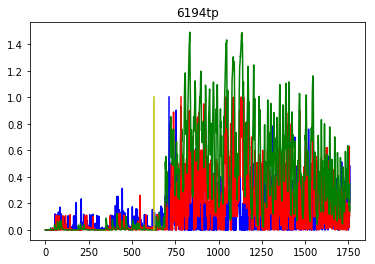

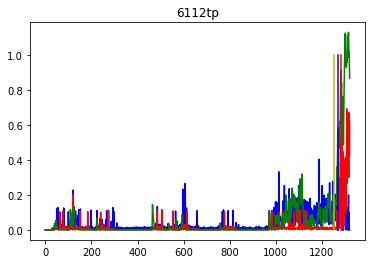

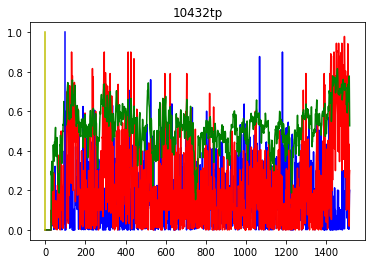

In [40]:
eval_vids(results_v['tp'], plot=True)

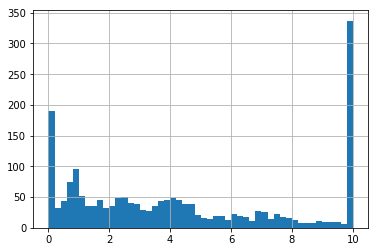

In [61]:
# good_df['r1'] = (good_df['rolling_ewm']/good_df['rolling_mean']).fillna(0).clip(0,10)
# good_df['r1'].hist(bins=50)
bad_df['r1'] = (bad_df['rolling_ewm']/bad_df['rolling_mean']).fillna(0).clip(0,10)
bad_df['r1'].hist(bins=50)
# ok_df['r1'] = (ok_df['rolling_ewm']/ok_df['rolling_mean']).fillna(0).clip(0,10)
# ok_df['r1'].hist(bins=50)

p1                0.249195
p2                0.143087
p3                0.094907
accu_detection    0.464675
rolling_ewm       0.401175
rolling_mean      0.140676
dtype: float64
p1                0.051069
p2                0.026682
p3                0.015408
accu_detection    0.243115
rolling_ewm       0.146625
rolling_mean      0.039075
dtype: float64
p1                0.091402
p2                0.042455
p3                0.026140
accu_detection    0.132129
rolling_ewm       0.104912
rolling_mean      0.068153
dtype: float64
p1                0.023180
p2                0.007343
p3                0.003422
accu_detection    0.079614
rolling_ewm       0.039488
rolling_mean      0.026788
dtype: float64
p1                0.023317
p2                0.010766
p3                0.006711
accu_detection    0.018861
rolling_ewm       0.018930
rolling_mean      0.022955
dtype: float64
p1                0.002753
p2                0.000570
p3                0.000175
accu_detection    0.006313
rolling

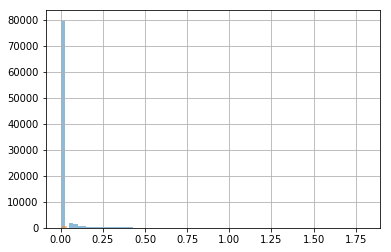

In [44]:
# bad_frames = []
# good_frames = []
# for vid in results['fp']:
#     start = detect_failure_start(vid, False)
#     df = load_detections(str(vid), thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43)
#     bad_frames += [df.loc[start:]]
#     good_frames += [df.loc[0:start]]
    
# bad_df_fp = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), bad_frames)
# good_df_fp = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), good_frames)

# print(bad_df_fp.mean())
# print(bad_df_fp.var())
# print(good_df_fp.mean())
# print(good_df_fp.var())


bad_frames = []
ok_frames = []
good_frames = []
ok_ratios = []
bad_ratios = []
for vid, video in failed_videos.iterrows():
    df = load_detections(str(vid), thresh = 0.06, ewm_span = 15, rolling_win = 460)
    ok_frames += [df.loc[video.start1:video.start1+20]]
    bad_frames += [df.loc[max(video.start1, video.start2-10):video.start2+20]]
    good_frames += [df.loc[50:video.start1]]
    ok_ratios += [good_frames[-1].p1.mean()/ok_frames[-1].p1.mean()]
    bad_ratios += [good_frames[-1].p1.mean()/bad_frames[-1].p1.mean()]
    
bad_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), bad_frames)
ok_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), ok_frames)
good_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), good_frames)

succeeded_vids = [load_detections(str(i), thresh = 0.16, ewm_span = 9, rolling_win = 50) for i in failure_starts[failure_starts.start1 >= MAX_FRAME_NUM].index]
succeeded_frames = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), succeeded_vids)

print(bad_df.mean())
print(bad_df.var())
print(ok_df.mean())
print(ok_df.var())
print(good_df.mean())
print(good_df.var())
print(succeeded_frames.mean())
print(succeeded_frames.var())
print(len(bad_df))
print(len(good_df))
print(len(succeeded_frames))
good_df.accu_detection.hist(bins=50, alpha=0.5)
bad_df.accu_detection.hist(bins=50, alpha=0.5)


In [28]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
#     print(x)
    hyper_vids = np.hstack((failed_videos.sample(40).index.values, succeeded_videos.sample(200).index.values))
    eval_res = eval_vids(vids, plot=False, thresh = x['thresh'], v_thresh = x['v_thresh'], min_ewm = x['min_ewm'], ewm_span = x['ewm_span'], rolling_win = x['rolling_win'], rolling_multiple = x['rolling_multiple'])
    eval_res['precision'] = len(eval_res['tp'])/max(len(eval_res['fp'])+len(eval_res['tp']),0.01)
    eval_res['recall'] = len(eval_res['tp'])/(len(eval_res['p']))
    eval_res['f1'] = 2*(eval_res['precision']*eval_res['recall'])/max(eval_res['precision']+eval_res['recall'], 0.01)
    eval_res['f0.5'] = (1+0.25)*(eval_res['precision']*eval_res['recall'])/max(0.25*eval_res['precision']+eval_res['recall'], 0.01)
    loss = 1 - eval_res['f0.5']
    print(loss)
    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'results': results,
        }

trials = Trials()

space = {
    'thresh': hp.quniform('thresh', 0.05, 0.3, 0.02),
    'v_thresh': hp.quniform('v_thresh', 1.5, 3, 0.1),
    'min_ewm': hp.quniform('min_ewm', 0.1, 0.8, 0.05),
    'ewm_span': hp.quniform('ewm_span', 2, 50, 1),
    'rolling_win': hp.quniform('rolling_win', 50, 500, 10),
    'rolling_multiple': hp.quniform('rolling_multiple', 1, 10, 0.2)
}
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials)


{'rolling_win': 140.0, 'v_thresh': 2.0, 'rolling_multiple': 2.2, 'ewm_span': 8.0, 'min_ewm': 0.75, 'thresh': 0.18}
0.6012931034482758                                    
{'rolling_win': 160.0, 'v_thresh': 2.8000000000000003, 'rolling_multiple': 9.0, 'ewm_span': 50.0, 'min_ewm': 0.4, 'thresh': 0.14}
1.0                                                                               
{'rolling_win': 90.0, 'v_thresh': 1.8, 'rolling_multiple': 8.0, 'ewm_span': 7.0, 'min_ewm': 0.5, 'thresh': 0.12}
0.644736842105263                                                                 
{'rolling_win': 400.0, 'v_thresh': 2.8000000000000003, 'rolling_multiple': 5.6000000000000005, 'ewm_span': 44.0, 'min_ewm': 0.4, 'thresh': 0.1}
0.6920289855072463                                                                
{'rolling_win': 60.0, 'v_thresh': 2.5, 'rolling_multiple': 9.4, 'ewm_span': 15.0, 'min_ewm': 0.2, 'thresh': 0.12}
1.0                                                                             

0.5681818181818182                                                                 
{'rolling_win': 100.0, 'v_thresh': 2.3000000000000003, 'rolling_multiple': 1.4000000000000001, 'ewm_span': 15.0, 'min_ewm': 0.55, 'thresh': 0.16}
0.5723684210526316                                                                 
{'rolling_win': 170.0, 'v_thresh': 2.4000000000000004, 'rolling_multiple': 1.0, 'ewm_span': 22.0, 'min_ewm': 0.35000000000000003, 'thresh': 0.14}
0.6989795918367347                                                                 
{'rolling_win': 200.0, 'v_thresh': 2.6, 'rolling_multiple': 4.6000000000000005, 'ewm_span': 18.0, 'min_ewm': 0.65, 'thresh': 0.12}
0.7321428571428572                                                                 
{'rolling_win': 130.0, 'v_thresh': 3.0, 'rolling_multiple': 1.6, 'ewm_span': 21.0, 'min_ewm': 0.30000000000000004, 'thresh': 0.16}
0.6680497925311204                                                                 
{'rolling_win': 70.0, 'v_t

0.5727848101265823                                                                  
{'rolling_win': 410.0, 'v_thresh': 1.8, 'rolling_multiple': 5.2, 'ewm_span': 10.0, 'min_ewm': 0.5, 'thresh': 0.18}
0.5918367346938775                                                                  
{'rolling_win': 340.0, 'v_thresh': 1.9000000000000001, 'rolling_multiple': 3.4000000000000004, 'ewm_span': 16.0, 'min_ewm': 0.6000000000000001, 'thresh': 0.14}
0.5357142857142858                                                                  
{'rolling_win': 390.0, 'v_thresh': 1.9000000000000001, 'rolling_multiple': 6.4, 'ewm_span': 18.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.18}
0.7817460317460317                                                                  
{'rolling_win': 310.0, 'v_thresh': 1.9000000000000001, 'rolling_multiple': 2.6, 'ewm_span': 12.0, 'min_ewm': 0.65, 'thresh': 0.24}
0.6237864077669902                                                                  
{'rolling_win': 340.0, '

0.5503597122302158                                                                   
{'rolling_win': 440.0, 'v_thresh': 1.6, 'rolling_multiple': 1.6, 'ewm_span': 21.0, 'min_ewm': 0.6000000000000001, 'thresh': 0.16}
0.5760869565217391                                                                   
{'rolling_win': 400.0, 'v_thresh': 2.1, 'rolling_multiple': 3.8000000000000003, 'ewm_span': 23.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.12}
0.7183098591549296                                                                   
{'rolling_win': 280.0, 'v_thresh': 2.0, 'rolling_multiple': 2.0, 'ewm_span': 10.0, 'min_ewm': 0.55, 'thresh': 0.14}
0.5977011494252873                                                                   
{'rolling_win': 350.0, 'v_thresh': 1.9000000000000001, 'rolling_multiple': 4.2, 'ewm_span': 17.0, 'min_ewm': 0.65, 'thresh': 0.1}
0.6677215189873418                                                                   
{'rolling_win': 370.0, 'v_thresh': 1.700000000000

{'rolling_win': 290.0, 'v_thresh': 2.2, 'rolling_multiple': 2.8000000000000003, 'ewm_span': 24.0, 'min_ewm': 0.65, 'thresh': 0.1}
0.6577380952380952                                                                   
{'rolling_win': 350.0, 'v_thresh': 1.9000000000000001, 'rolling_multiple': 7.6000000000000005, 'ewm_span': 19.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.12}
0.8093220338983051                                                                   
{'rolling_win': 240.0, 'v_thresh': 2.5, 'rolling_multiple': 2.0, 'ewm_span': 11.0, 'min_ewm': 0.65, 'thresh': 0.26}
0.6064814814814815                                                                   
{'rolling_win': 300.0, 'v_thresh': 2.4000000000000004, 'rolling_multiple': 4.800000000000001, 'ewm_span': 2.0, 'min_ewm': 0.55, 'thresh': 0.08}
0.7589974293059126                                                                   
{'rolling_win': 370.0, 'v_thresh': 2.6, 'rolling_multiple': 3.2, 'ewm_span': 16.0, 'min_ewm': 0.75, 'thres

0.7021943573667712                                                      
{'rolling_win': 340.0, 'v_thresh': 2.5, 'rolling_multiple': 3.0, 'ewm_span': 16.0, 'min_ewm': 0.6000000000000001, 'thresh': 0.06}
0.532608695652174                                                       
{'rolling_win': 300.0, 'v_thresh': 2.7, 'rolling_multiple': 1.6, 'ewm_span': 24.0, 'min_ewm': 0.55, 'thresh': 0.22}
0.6144859813084111                                                      
{'rolling_win': 360.0, 'v_thresh': 2.6, 'rolling_multiple': 2.4000000000000004, 'ewm_span': 9.0, 'min_ewm': 0.6000000000000001, 'thresh': 0.06}
0.5784023668639053                                                      
{'rolling_win': 450.0, 'v_thresh': 2.7, 'rolling_multiple': 3.0, 'ewm_span': 21.0, 'min_ewm': 0.8, 'thresh': 0.06}
0.7007042253521126                                                      
{'rolling_win': 340.0, 'v_thresh': 2.6, 'rolling_multiple': 1.4000000000000001, 'ewm_span': 12.0, 'min_ewm': 0.7000000000000001, '

0.6875                                                                  
{'rolling_win': 410.0, 'v_thresh': 2.7, 'rolling_multiple': 1.6, 'ewm_span': 3.0, 'min_ewm': 0.55, 'thresh': 0.16}
0.7038461538461538                                                      
{'rolling_win': 270.0, 'v_thresh': 2.3000000000000003, 'rolling_multiple': 4.2, 'ewm_span': 18.0, 'min_ewm': 0.45, 'thresh': 0.18}
0.5869565217391304                                                      
{'rolling_win': 380.0, 'v_thresh': 2.5, 'rolling_multiple': 2.0, 'ewm_span': 21.0, 'min_ewm': 0.65, 'thresh': 0.06}
0.5756880733944953                                                      
{'rolling_win': 360.0, 'v_thresh': 3.0, 'rolling_multiple': 3.8000000000000003, 'ewm_span': 13.0, 'min_ewm': 0.65, 'thresh': 0.08}
0.5432692307692307                                                      
{'rolling_win': 300.0, 'v_thresh': 2.2, 'rolling_multiple': 1.8, 'ewm_span': 10.0, 'min_ewm': 0.6000000000000001, 'thresh': 0.14}
0.5727848101

0.5910493827160495                                                      
{'rolling_win': 420.0, 'v_thresh': 2.5, 'rolling_multiple': 2.4000000000000004, 'ewm_span': 17.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.08}
0.625                                                                   
{'rolling_win': 350.0, 'v_thresh': 2.1, 'rolling_multiple': 2.0, 'ewm_span': 21.0, 'min_ewm': 0.6000000000000001, 'thresh': 0.06}
0.5426829268292683                                                      
{'rolling_win': 320.0, 'v_thresh': 2.5, 'rolling_multiple': 1.2000000000000002, 'ewm_span': 13.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.08}
0.5643939393939393                                                      
{'rolling_win': 370.0, 'v_thresh': 2.2, 'rolling_multiple': 1.6, 'ewm_span': 15.0, 'min_ewm': 0.75, 'thresh': 0.1}
0.6428571428571429                                                      
{'rolling_win': 390.0, 'v_thresh': 2.4000000000000004, 'rolling_multiple': 2.4000000000000004, 'ewm_

{'rolling_win': 380.0, 'v_thresh': 1.9000000000000001, 'rolling_multiple': 2.6, 'ewm_span': 23.0, 'min_ewm': 0.75, 'thresh': 0.12}
0.6959459459459458                                                      
{'rolling_win': 340.0, 'v_thresh': 2.3000000000000003, 'rolling_multiple': 2.4000000000000004, 'ewm_span': 7.0, 'min_ewm': 0.65, 'thresh': 0.12}
0.5858895705521472                                                      
{'rolling_win': 310.0, 'v_thresh': 1.5, 'rolling_multiple': 3.2, 'ewm_span': 16.0, 'min_ewm': 0.8, 'thresh': 0.26}
0.7101449275362319                                                      
{'rolling_win': 280.0, 'v_thresh': 2.0, 'rolling_multiple': 1.6, 'ewm_span': 6.0, 'min_ewm': 0.65, 'thresh': 0.1}
0.6025641025641026                                                      
{'rolling_win': 210.0, 'v_thresh': 1.8, 'rolling_multiple': 4.4, 'ewm_span': 18.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.14}
0.7463768115942029                                                      


0.5868644067796611                                                                    
{'rolling_win': 470.0, 'v_thresh': 2.3000000000000003, 'rolling_multiple': 1.8, 'ewm_span': 9.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.06}
0.5748299319727892                                                                    
{'rolling_win': 490.0, 'v_thresh': 2.4000000000000004, 'rolling_multiple': 2.0, 'ewm_span': 13.0, 'min_ewm': 0.65, 'thresh': 0.06}
0.5277777777777778                                                                    
{'rolling_win': 440.0, 'v_thresh': 2.3000000000000003, 'rolling_multiple': 2.6, 'ewm_span': 10.0, 'min_ewm': 0.75, 'thresh': 0.06}
0.5543478260869565                                                                    
{'rolling_win': 460.0, 'v_thresh': 2.2, 'rolling_multiple': 2.4000000000000004, 'ewm_span': 13.0, 'min_ewm': 0.7000000000000001, 'thresh': 0.06}
0.5581896551724137                                                                    
{'rolling_win'

KeyboardInterrupt: 

Text(0, 0.5, '$val$')

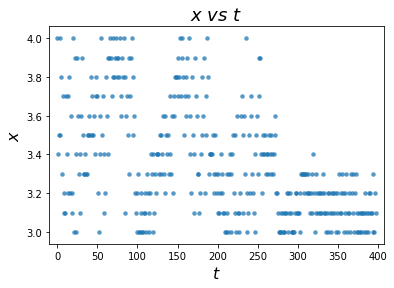

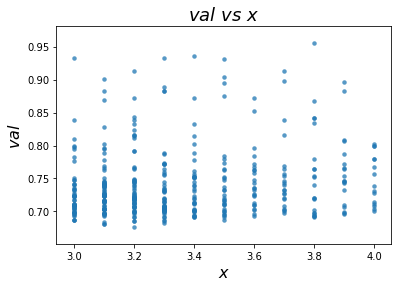

In [47]:
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials[:-1]]
ys = [t['misc']['vals']['rolling_multiple'] for t in trials.trials[:-1]]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

f, ax = plt.subplots(1)
xs = [t['misc']['vals']['rolling_multiple'] for t in trials.trials[:-1]]
ys = [t['result']['loss'] for t in trials.trials[:-1]]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

In [31]:
tdf = pd.DataFrame([{**t['misc']['vals'], **dict(loss=[t['result']['loss']])} for t in trials.trials[:-1]])
tdf = tdf.applymap(lambda x: x[0])
tdf[tdf.loss < 63 ].corr()
# tdf.corr()
# rolling_multiple = 3-4
# rolling_win > 150
# min_ewm > 0.3
# ewm_span 12 - 20
# v_thresh > 1.5
# thresh 0.05 - 0.3
tdf.sort_values(by=['loss']).head(50)

,ewm_span,loss,min_ewm,rolling_multiple,rolling_win,thresh,v_thresh
568,15.0,0.517717,0.65,2.2,460.0,0.06,2.4
274,16.0,0.520000,0.60,2.0,250.0,0.12,2.3
578,13.0,0.520677,0.65,2.2,480.0,0.06,2.4
589,13.0,0.520677,0.65,2.2,440.0,0.06,2.4
577,13.0,0.521484,0.65,2.4,430.0,0.06,2.4
265,14.0,0.523305,0.65,2.4,350.0,0.12,2.3
416,13.0,0.524254,0.65,2.2,360.0,0.06,2.1
354,17.0,0.526210,0.60,2.2,420.0,0.12,1.7
585,13.0,0.527778,0.65,2.0,490.0,0.06,2.4
579,11.0,0.530000,0.70,2.4,480.0,0.06,2.3


In [187]:
# Hyperparameter grid search

thresh_arr = np.linspace(0.05, 0.3, 3)
v_thresh_arr = np.linspace(1.5, 3, 2)
min_ewm_arr = np.linspace(0.3, 0.7, 3)
ewm_span_arr = np.linspace(2, 30, 3)
rolling_win_arr = np.linspace(150, 300, 5)
rolling_multiple_arr = np.linspace(3, 4, 2)

loss_arr = []
for r in np.array(np.meshgrid(thresh_arr, v_thresh_arr, min_ewm_arr, ewm_span_arr, rolling_win_arr, rolling_multiple_arr)).T.reshape(-1,6):
    loss_arr += [objective(dict(thresh=r[0], v_thresh=r[1], min_ewm=r[2], ewm_span=r[3], rolling_win=r[4], rolling_multiple=r[5]))]


{'v_thresh': 1.5, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
674
{'v_thresh': 3.0, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
674
{'v_thresh': 1.5, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.175}
547
{'v_thresh': 3.0, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.175}
547
{'v_thresh': 1.5, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.3}
470
{'v_thresh': 3.0, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.3}
470
{'v_thresh': 1.5, 'min_ewm': 0.5, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
367
{'v_thresh': 3.0, 'min_ewm': 0.5, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
367
{'v_thresh': 1.5, 'min_ewm': 0.5, 'rolling_win': 150.0, 

KeyboardInterrupt: 